# RL Assignment - Ulysse Roux

In [206]:
from collections import defaultdict
import os, sys
import time
from tqdm import tqdm

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import text_flappy_bird_gym
from rl_glue import RLGlue
import agent

### Test the environment

In [207]:
def random_playing(env: gym.Env, visualize=True):
    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
        
        if visualize:
            # Render the game
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()
    return info

In [208]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)


In [209]:
env.reset()
random_playing(env, visualize=True)

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-3)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=-1)
Text Flappy Bird!
Score: 0
----------------------
[     

{'score': 0, 'player': [6, 2], 'distance': np.float64(8.0)}

In [210]:
# Compute the mean of the scores in 100000 random games
scores = []
for _ in range(100000):
    env.reset()
    scores.append(random_playing(env, visualize=False)['score'])
print(f"The average score with random plays is {np.mean(scores):.2f}")

The average score with random plays is 0.16


Let us improve this mean score by training RL agents

## 1. Monte-Carlo Control

#### Implement MCC functions

In [211]:
def generate_episode_from_Q(env, Q, epsilon, nA, random_generator):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state, _ = env.reset()
    while True:
        if state in Q:
            action = random_generator.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))
        else:
            action = env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, _, info = env.step(action)
        episode.append((state, action, reward, info))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * (epsilon / nA)
    best_a = np.argmax(Q_s)
    policy_s[best_a] += (1 - epsilon)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards, _ = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha * (sum(rewards[i:] * discounts[:-(1+i)]) - old_Q)
    return Q

def mc_control(env, num_runs, num_episodes, agent_info, visualize):
    all_reward_sums = []
    scores = []
    nA = env.action_space.n
    epsilon = agent_info["eps_start"]
    for i_run in tqdm(range(1, num_runs + 1)):
        reward_sums = []
        random_generator = np.random.RandomState(i_run)
        Q = defaultdict(lambda: np.zeros(nA))
        for i_episode in range(1, num_episodes+1):
            epsilon = max(epsilon*agent_info["eps_decay"], agent_info["eps_min"])
            episode = generate_episode_from_Q(env, Q, epsilon, nA, random_generator)
            Q = update_Q(env, episode, Q, agent_info["alpha"], agent_info["gamma"])
            reward_sums.append(sum(step[2] for step in episode))

        scores.append(episode[-1][3]['score'])
        all_reward_sums.append(reward_sums)

    if visualize:
        plt.plot(np.mean(all_reward_sums, axis=0), label="MC Control")
        plt.xlabel("Episodes")
        plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
        plt.xlim(0,num_episodes)
        #plt.ylim(0, 100)
        plt.legend()
        plt.show()

        print(f"The mean score over all runs is : {np.mean(scores)}")
        return

    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

#### Train the MCC agent and get the policy, action-value function and state-value function

100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


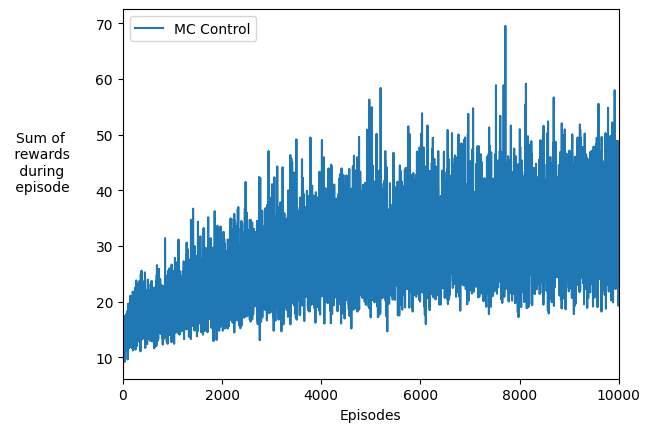

The mean score over all runs is : 2.2


In [212]:
# obtain the estimated optimal policy and action-value function
agent_info = {"alpha":0.02, "gamma":1.0, "eps_start":1.0, "eps_decay":0.99999, "eps_min":0.05}
mc_control(env, num_runs=20, num_episodes=10000, agent_info=agent_info, visualize=True)

Our MCC agent reached the score 100. If we did not stop it, it would have won for a long time.

#### Visualizations

In [213]:
def get_ranges(V):
    dx_min, dx_max, dy_min, dy_max = np.inf, -np.inf, np.inf, -np.inf
    for dx, dy in V.keys():
        if dx > dx_max:
            dx_max = dx
        if dx < dx_min:
            dx_min = dx
        if dy > dy_max:
            dy_max = dy
        if dy < dy_min:
            dy_min = dy
    return dx_min, dx_max, dy_min, dy_max

In [214]:
def plot_state_value_function(V):
    # Create a grid of (dx, dy) values
    dx_min, dx_max, dy_min, dy_max = get_ranges(V)
    dx_values = np.arange(dx_min, dx_max + 1)
    dy_values = np.arange(dy_min, dy_max + 1)
    
    # Initialize a 2D array for values
    value_grid = np.zeros((len(dy_values), len(dx_values)))
    
    # Fill the grid with values from V
    for i, dy in enumerate(dy_values):
        for j, dx in enumerate(dx_values):
            value_grid[i, j] = V.get((dx, dy), 0.0)  # Default to 0 if state not in V
    
    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(value_grid, cmap='viridis', origin='lower',
               extent=[dx_min - 0.5, dx_max + 0.5, dy_min - 0.5, dy_max + 0.5])
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.colorbar(label='State-Value (V)')
    plt.xlabel('Distance from Pipe (dx)')
    plt.ylabel('Vertical Distance (dy)')
    plt.title('State-Value Function Heatmap')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

100%|██████████| 1/1 [00:33<00:00, 33.95s/it]


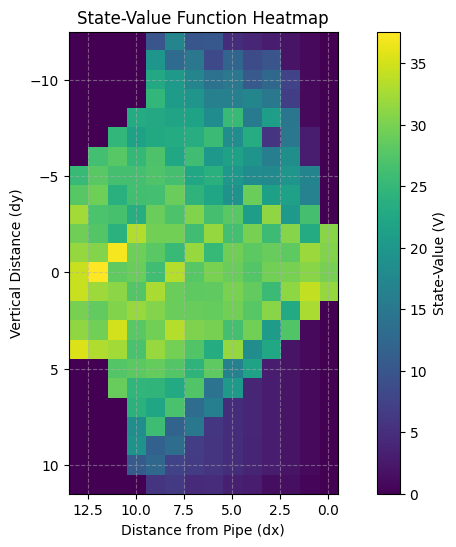

In [215]:
policy, Q = mc_control(env, num_runs=1, num_episodes=100000, agent_info=agent_info, visualize=False)
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())
plot_state_value_function(V)

The game dynamics favor control when moving upward rather than free fall. The environment penalizes high-altitude mistakes more than low-altitude ones. Recovery options are more abundant when the bird goes up than when it goed down, shaping the value landscape asymmetrically. Particularly, we can see the stair effect when the bird is below the pipe gap. States near obstacles exhibit lower long-term rewards, while strategic positioning enhances survival chances. The inherent physics of movement and constraints define the optimal zones for action.

#### Play a game with this new policy

In [216]:
state, _ = env.reset()
while True:

    # Select next action
    action = policy[state]  # for an agent, action = agent.policy(observation)
    state, reward, done, _, info = env.step(action)
    
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break
    if info['score'] == 100:
        print("Our agent reached the max score : 100")
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-4)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-5)
Text Flappy Bird!
Score: 0
----------------------
[     

## 2. SARSA Agent

In [ ]:
class SarsaAgent:
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
            lambda (float): The trace-decay parameter,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.lambd = agent_init_info["lambda"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.num_actions))  # The array of action-value estimates.
        self.eligibility = defaultdict(lambda: np.zeros(self.num_actions))  # Eligibility traces

    def reset_eligibility_traces(self):
        """Reset all eligibility traces to zero."""
        self.eligibility = defaultdict(lambda: np.zeros(self.num_actions))

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        # Reset eligibility traces at the start of each episode
        self.reset_eligibility_traces()
        
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Increment eligibility trace for current state-action pair
        self.eligibility[state][action] += 1
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        # Choose next action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Calculate TD error
        td_error = reward + self.discount * self.q[state][action] - self.q[self.prev_state][self.prev_action]
        
        # Update all state-action pairs according to their eligibility traces
        for s in self.eligibility:
            for a in range(self.num_actions):
                if self.eligibility[s][a] > 0:
                    self.q[s][a] += self.step_size * td_error * self.eligibility[s][a]
                    # Decay eligibility traces
                    self.eligibility[s][a] *= self.discount * self.lambd
        
        # Increment eligibility trace for current state-action pair
        self.eligibility[state][action] += 1
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # For terminal state, there's no next action
        td_error = reward - self.q[self.prev_state][self.prev_action]
        
        # Update all state-action pairs according to their eligibility traces
        for s in self.eligibility:
            for a in range(self.num_actions):
                if self.eligibility[s][a] > 0:
                    self.q[s][a] += self.step_size * td_error * self.eligibility[s][a]
                    # Decay eligibility traces
                    self.eligibility[s][a] *= self.discount * self.lambd

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [ ]:
def run_sarsa_agent(env, agent_params, num_runs=100, num_episodes=1000, visualize = True):
    """
    Run the Sarsa Agent in a Gym environment.
    
    Args:
        env_name (str): Name of the Gym environment (e.g., 'CartPole-v1')
        agent_params (dict): Parameters for the agent
        num_episodes (int): Number of episodes to run
        max_steps (int): Maximum steps per episode
    """
    env.reset()
    agent_params["num_states"] = (env.observation_space[0].n, env.observation_space[1].n)
    agent_params["num_actions"] = env.action_space.n

    all_reward_sums = []
    scores = []
    
    # Initialize your agent
    agent = SarsaAgent()
    
    # Training loop
    for run in tqdm(range(num_runs)):
        agent_params['seed'] = run
        agent.agent_init(agent_params)
        reward_sums = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            action = agent.agent_start(state)
            state, reward, done, _, info = env.step(action)
            total_reward = reward
            while not done: 
                action = agent.agent_step(reward, state)
                state, reward, done, _, info = env.step(action)
                total_reward += reward
            agent.agent_end(reward)
            reward_sums.append(total_reward)
        scores.append(info["score"])
        all_reward_sums.append(reward_sums)
    
    if visualize:
        plt.plot(np.mean(all_reward_sums, axis=0), label="SARSA")
        plt.xlabel("Episodes")
        plt.ylabel("Sum of rewards during episode")
        # plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
        plt.xlim(0,1000)
        #plt.ylim(0, 100)
        plt.legend()
        plt.show()

        print(f"The mean score over all runs is : {np.mean(scores)}")
    return agent.q


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


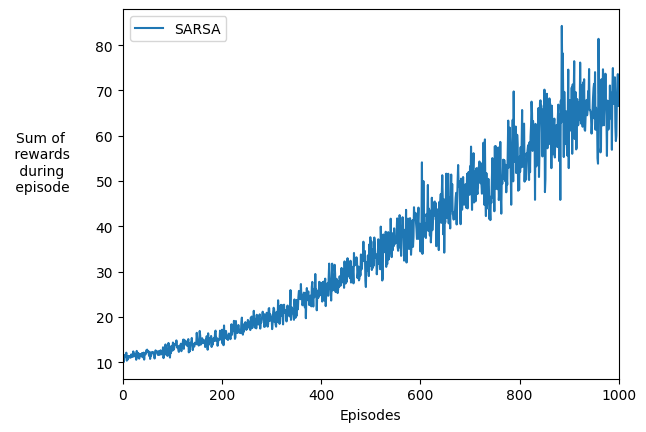

The mean score over all runs is : 5.48


defaultdict(<function __main__.ExpectedSarsaAgent.agent_init.<locals>.<lambda>()>,
            {(13, 0): array([60.91640469, 19.25326549]),
             (12, -1): array([59.91480351, 28.04200688]),
             (11, 0): array([22.76038701,  0.        ]),
             (10, 3): array([ 0.        , 18.93260431]),
             (9, 2): array([48.96387998, 59.11083263]),
             (8, 3): array([40.5216589 , 55.73613975]),
             (7, 2): array([41.07734335, 56.33223752]),
             (6, 3): array([49.59441438, 55.80262025]),
             (5, 6): array([ 0.875     , 32.61334437]),
             (4, 5): array([ 1.6569621 , 38.55964977]),
             (3, 6): array([2.04903823, 0.7375    ]),
             (13, -2): array([21.87314503, 56.46120446]),
             (12, -3): array([25.80990862, 58.38407386]),
             (11, -4): array([57.23814022, 47.93472407]),
             (10, -3): array([46.97167777, 59.17242834]),
             (9, -4): array([59.42205094, 54.3704443 ]),
         

In [ ]:
SARSA_AGENT_INFO = {"epsilon": 0.1, "step_size": 0.5, "discount": 1.0, "lambda":0.5}
run_sarsa_agent(env, SARSA_AGENT_INFO)

100%|██████████| 1/1 [03:27<00:00, 207.32s/it]


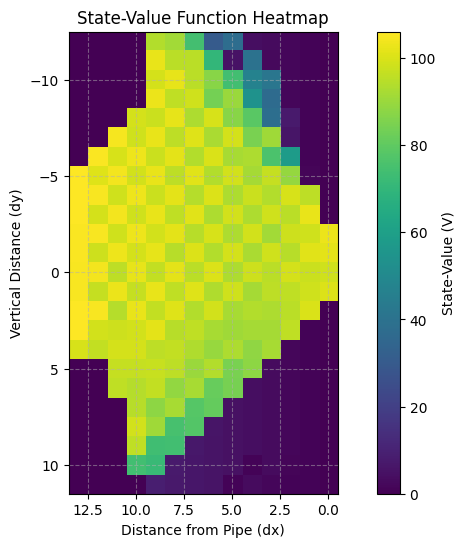

In [ ]:
SARSA_Q = run_sarsa_agent(env, SARSA_AGENT_INFO, num_runs=1, num_episodes=100000, visualize=False)
SARSA_V = dict((k,np.max(v)) for k, v in SARSA_Q.items())
plot_state_value_function(SARSA_V)

This state-value function, obtained using the SARSA algorithm, exhibits a smoother and more optimistic value distribution compared to MC Control. The most noticeable feature is the broader, high-value region, indicating that SARSA's on-policy updates favor safer, long-term strategies rather than purely maximizing immediate rewards. The vertical asymmetry remains present, reinforcing the difficulty of recovery from states above the pipe gap due to gravity and limited control. Additionally, the presence of a lower-value strip along the right side suggests that SARSA has learned a cautious approach when approaching obstacles, likely due to the inherent risk of immediate failure. This aligns with SARSA’s tendency to propagate values in a way that accounts for suboptimal future actions, making the agent more risk-averse compared to greedy policies.

#### Play a game with this new policy

In [221]:
SARSA_POLICY = dict((k,np.argmax(v)) for k, v in SARSA_Q.items())
state, _ = env.reset()
while True:

    # Select next action
    action = SARSA_POLICY[state]  # for an agent, action = agent.policy(observation)
    state, reward, done, _, info = env.step(action)
    
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break
    if info['score'] == 100:
        print("Our agent reached the max score : 100")
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-2)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-3)
Text Flappy Bird!
Score: 0
----------------------
[     

We also reached the score 100.

## Sweep parameters of env 

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


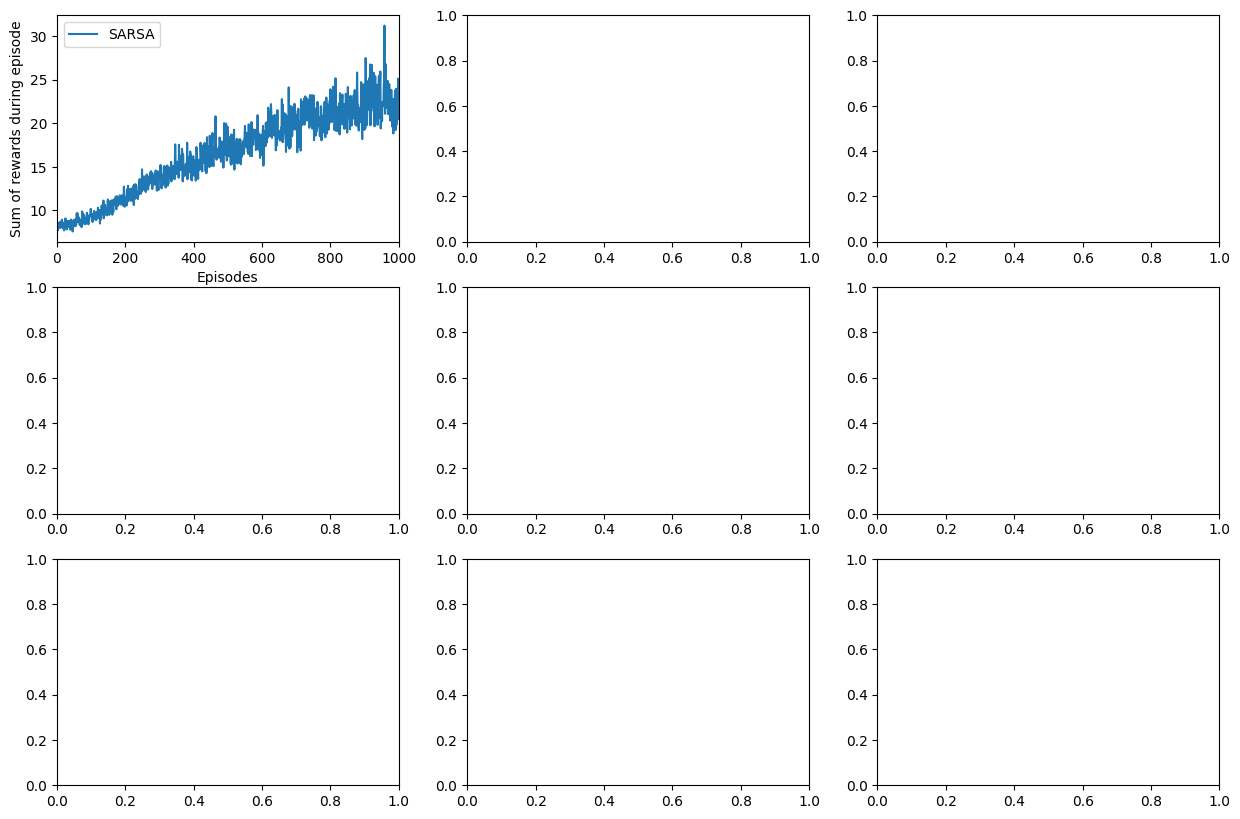

The mean score over all runs is : 1.73


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


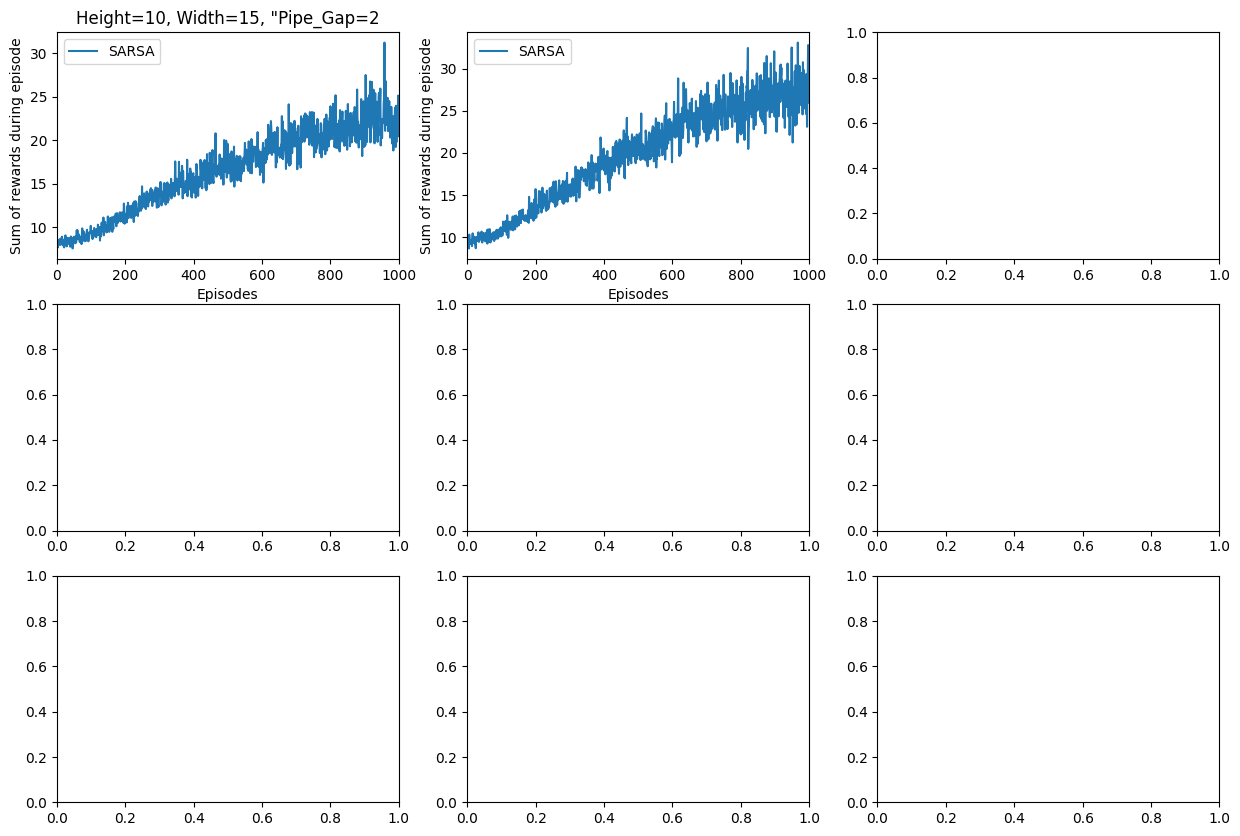

The mean score over all runs is : 1.43


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


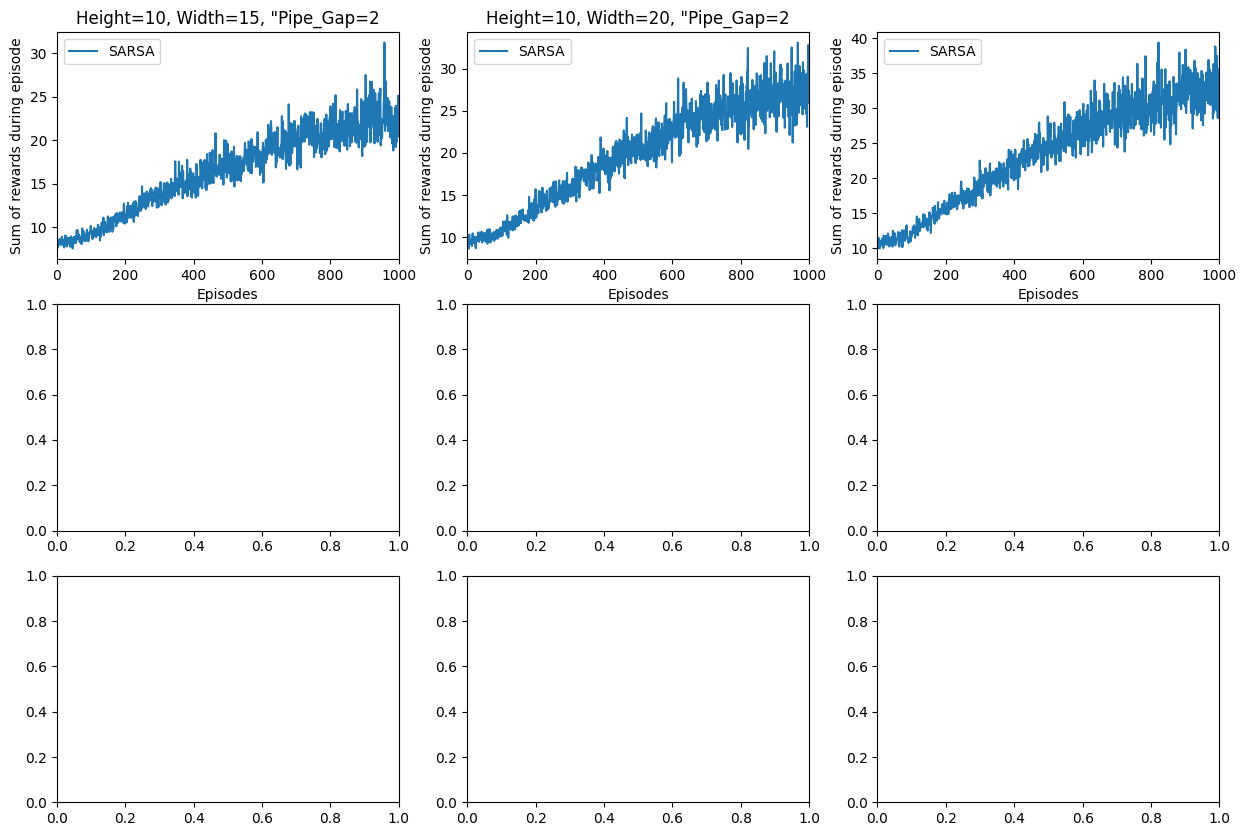

The mean score over all runs is : 1.61


100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


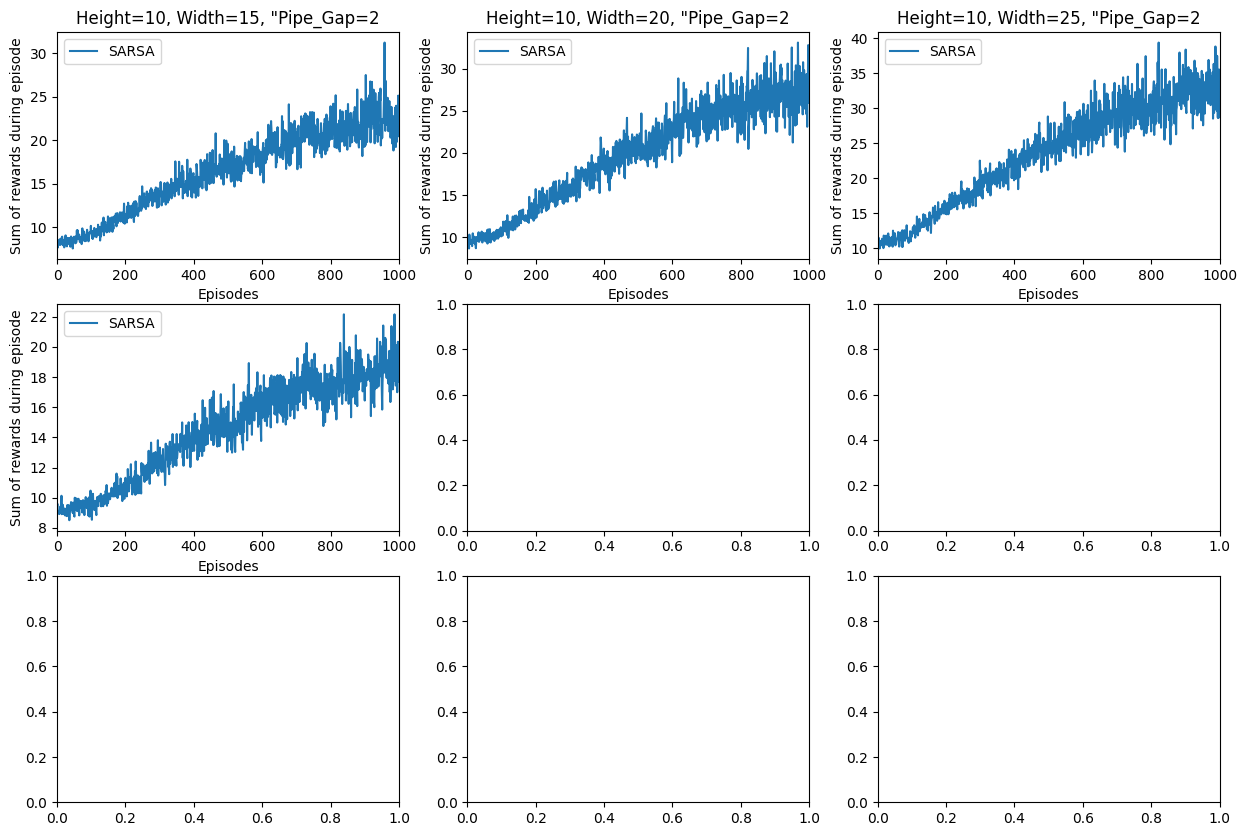

The mean score over all runs is : 1.01


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


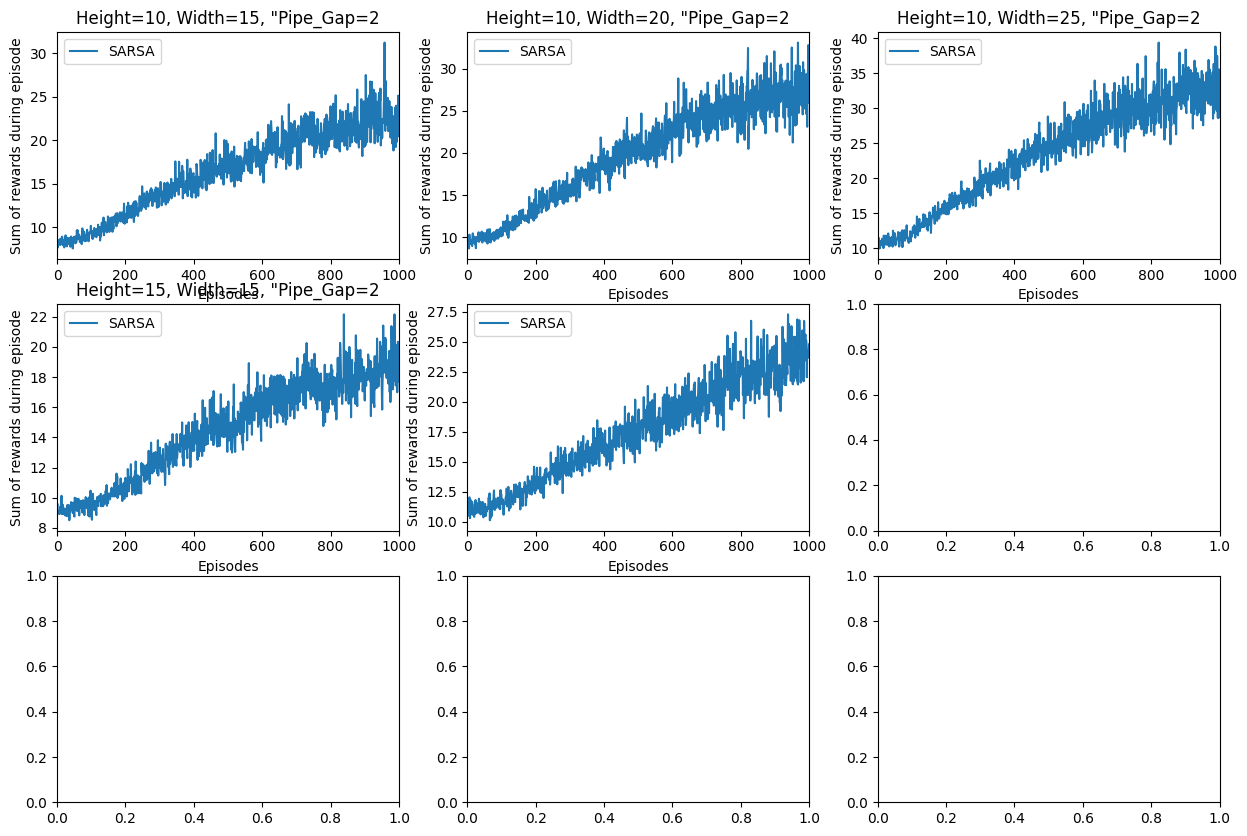

The mean score over all runs is : 1.32


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


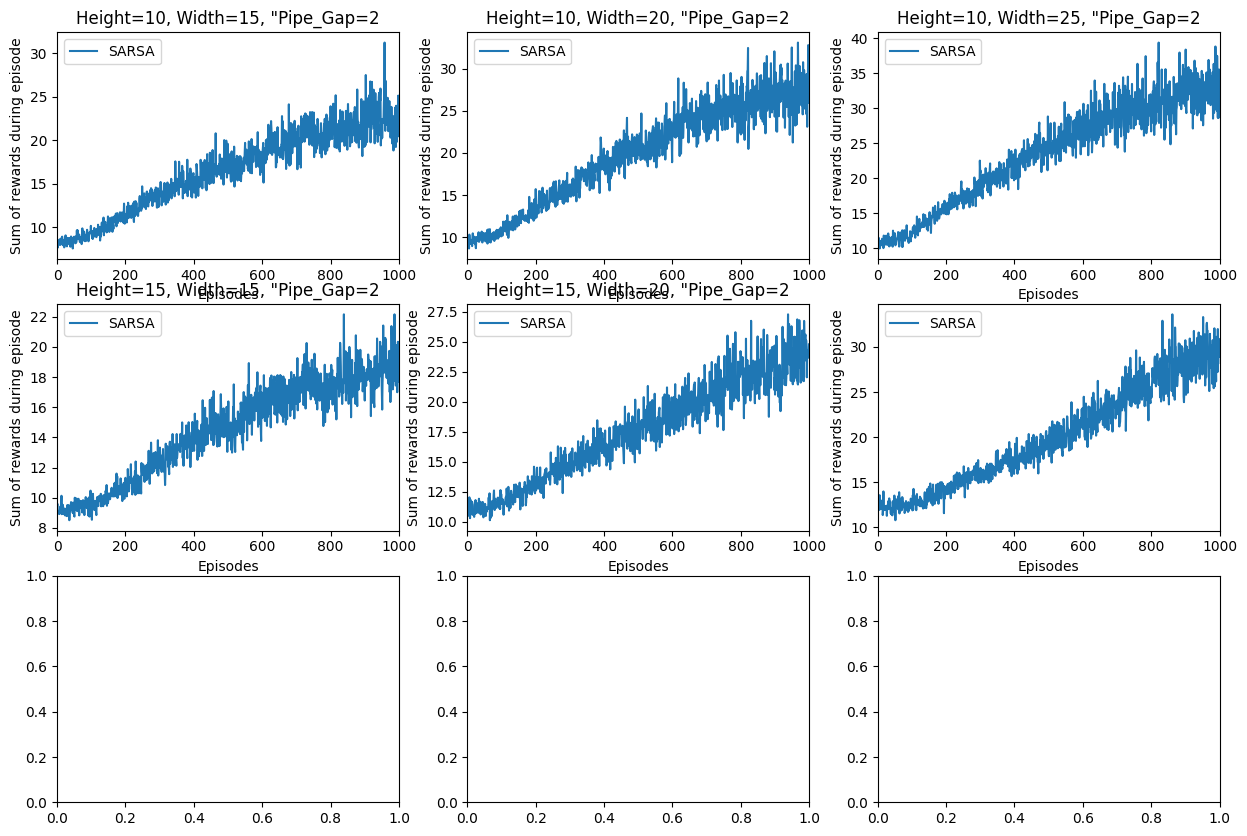

The mean score over all runs is : 1.08


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


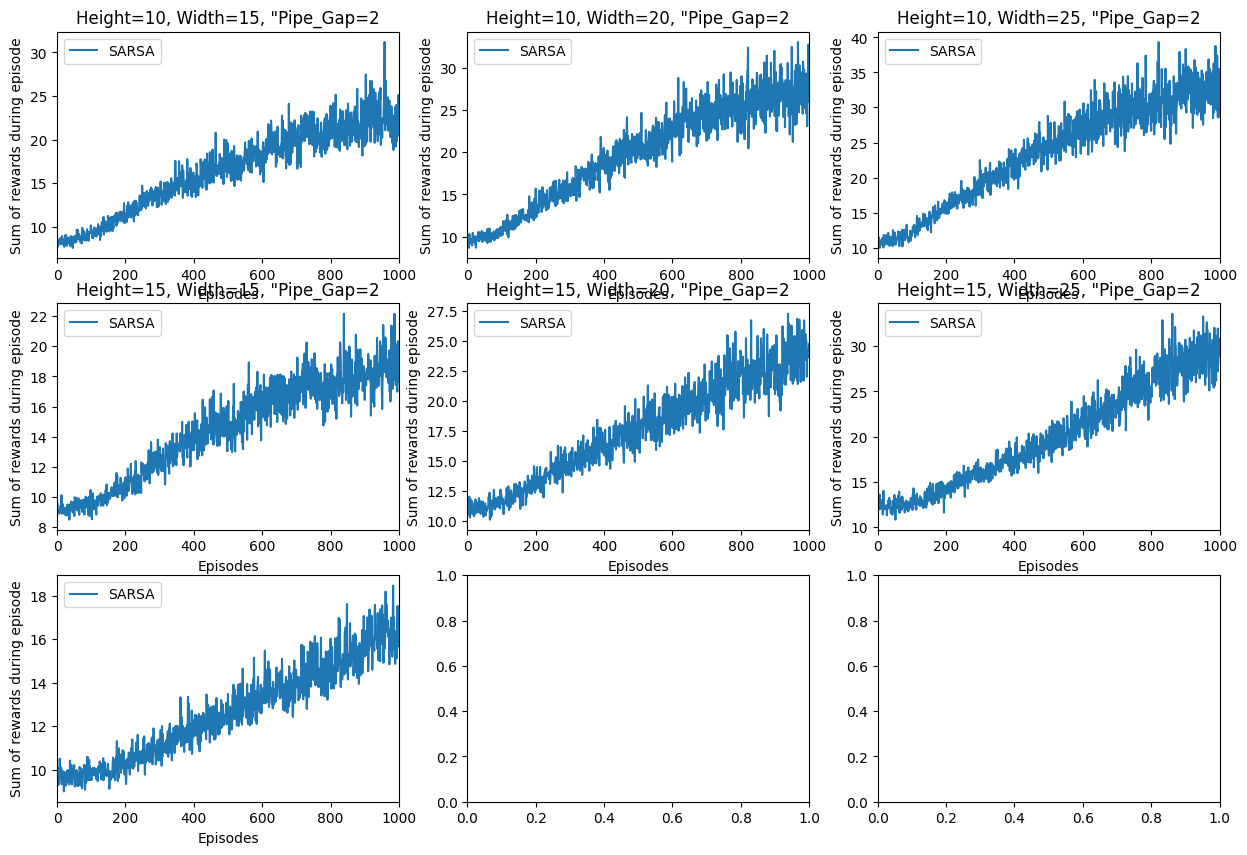

The mean score over all runs is : 0.94


100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


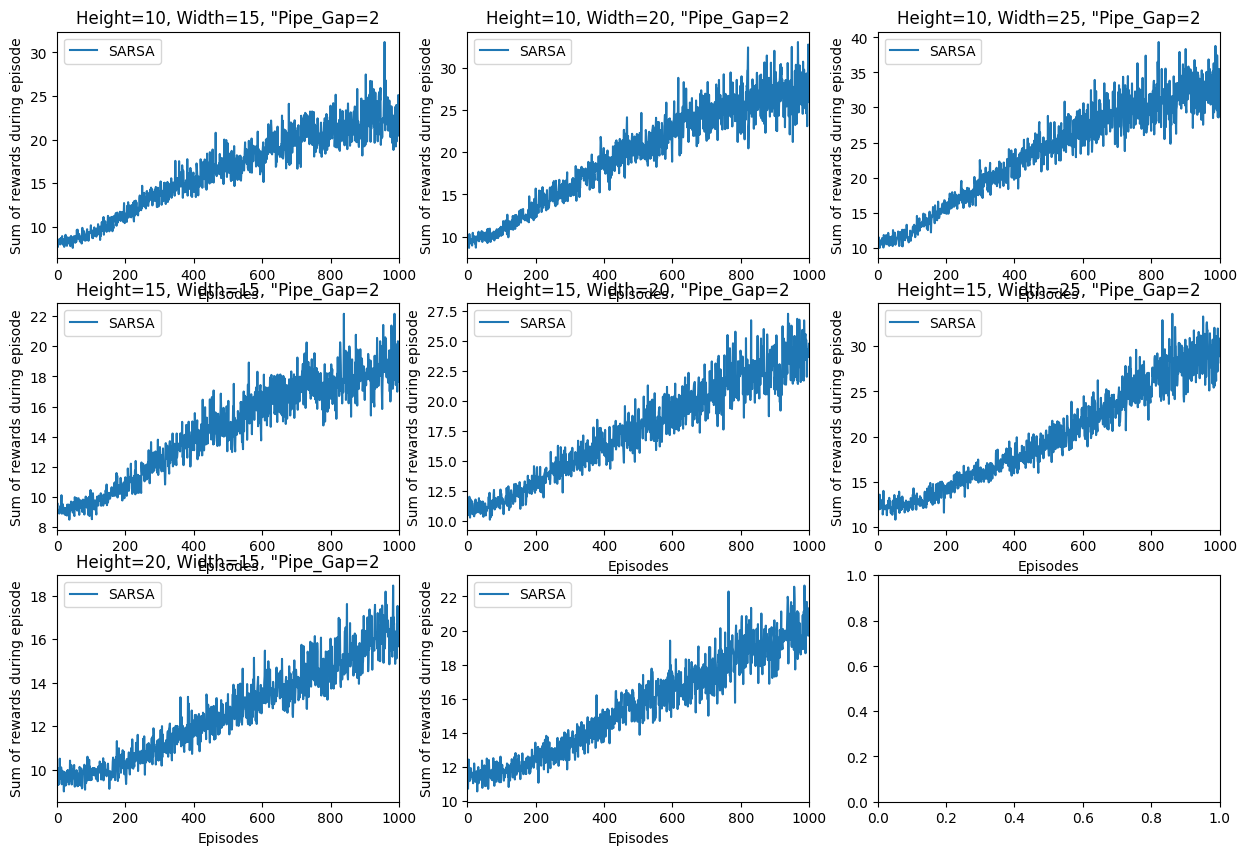

The mean score over all runs is : 0.8


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


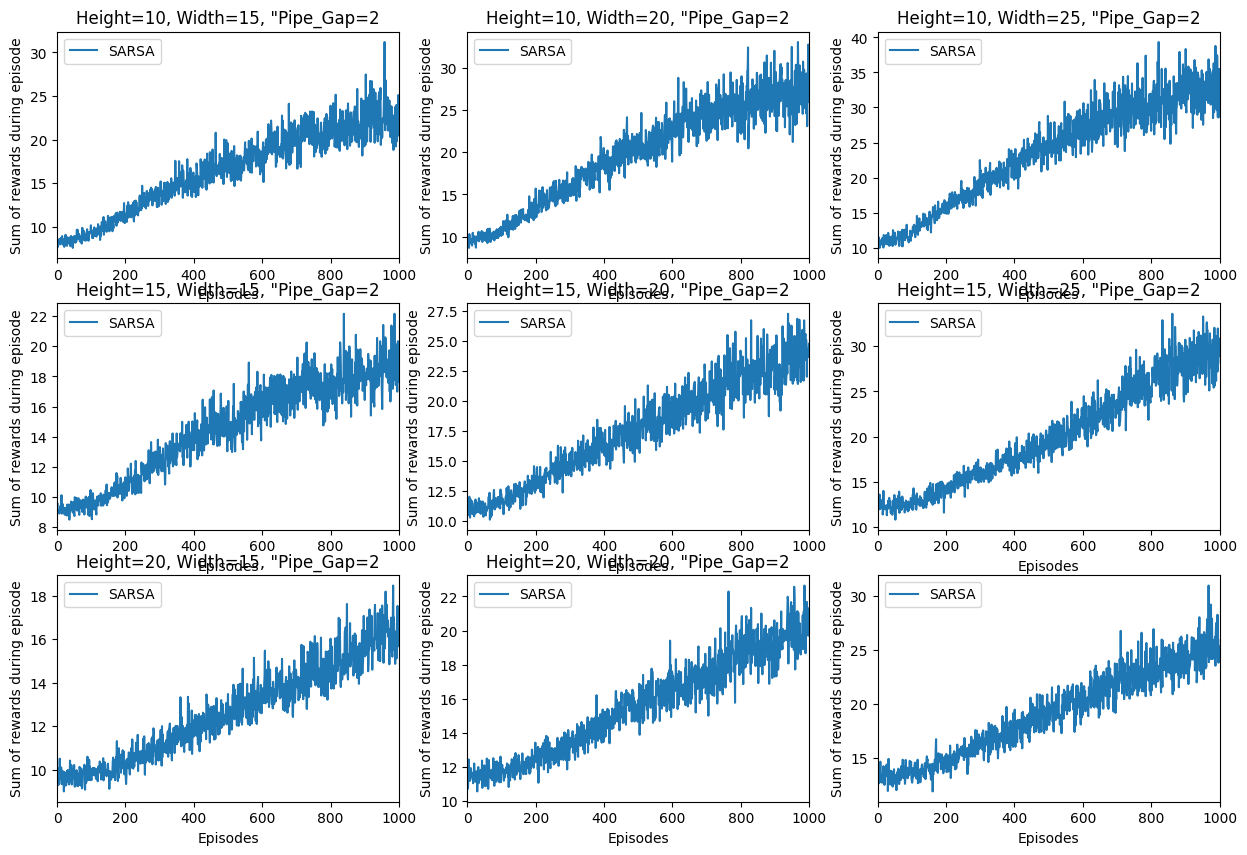

The mean score over all runs is : 0.75


<Figure size 640x480 with 0 Axes>

100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


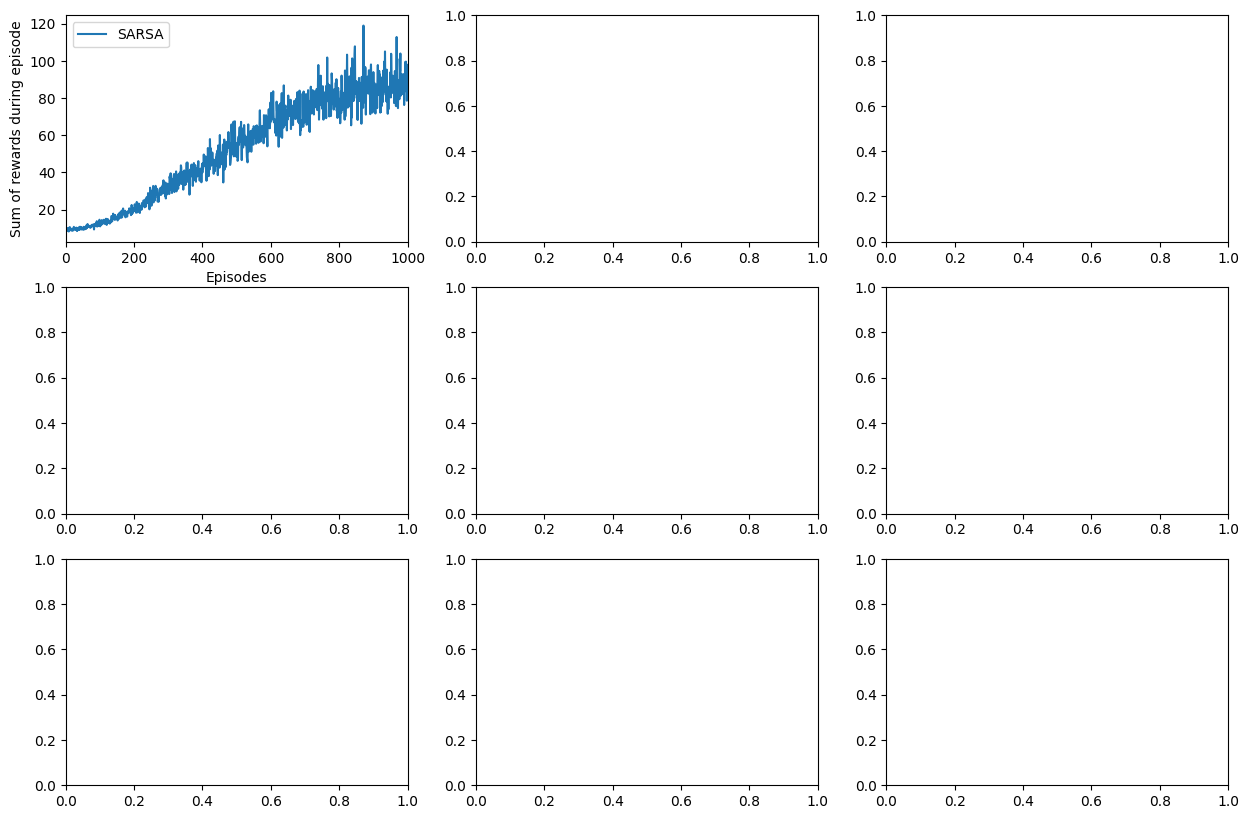

The mean score over all runs is : 11.14


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


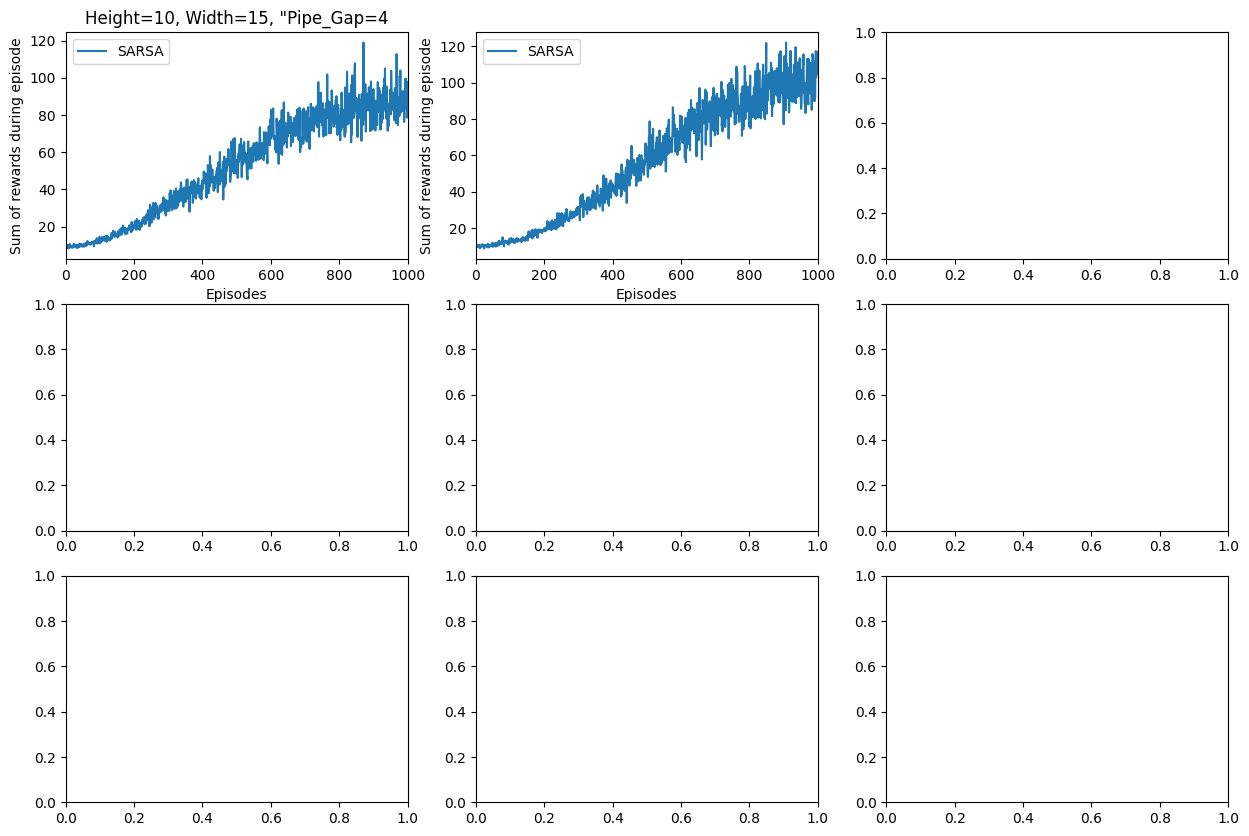

The mean score over all runs is : 10.61


100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


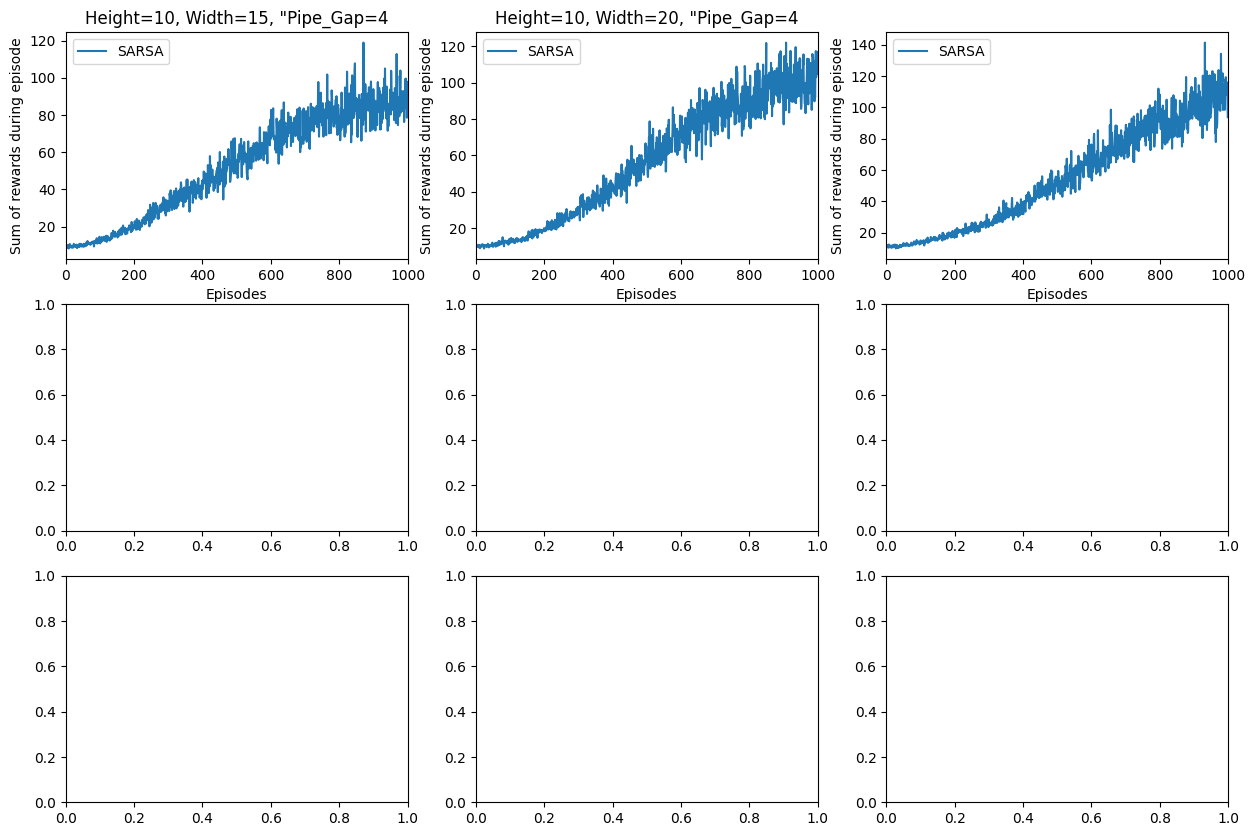

The mean score over all runs is : 6.1


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


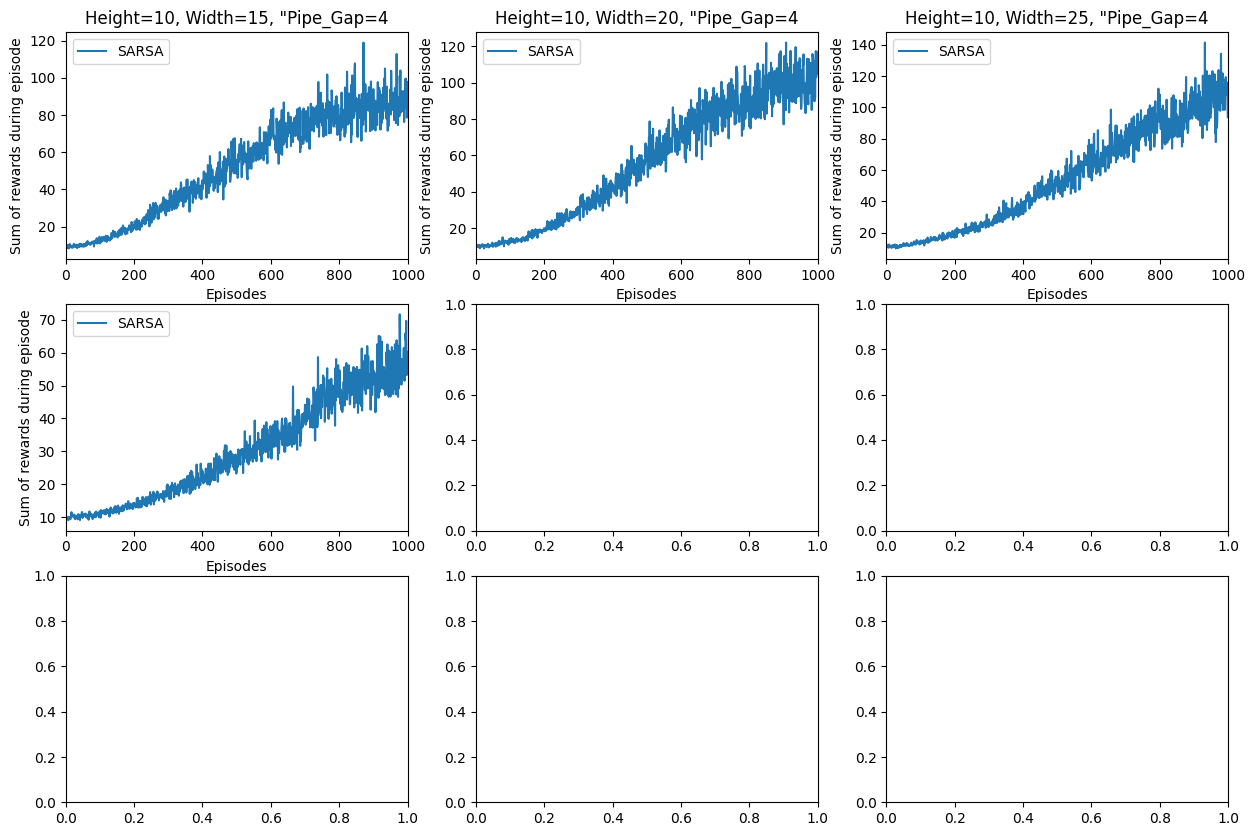

The mean score over all runs is : 6.38


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


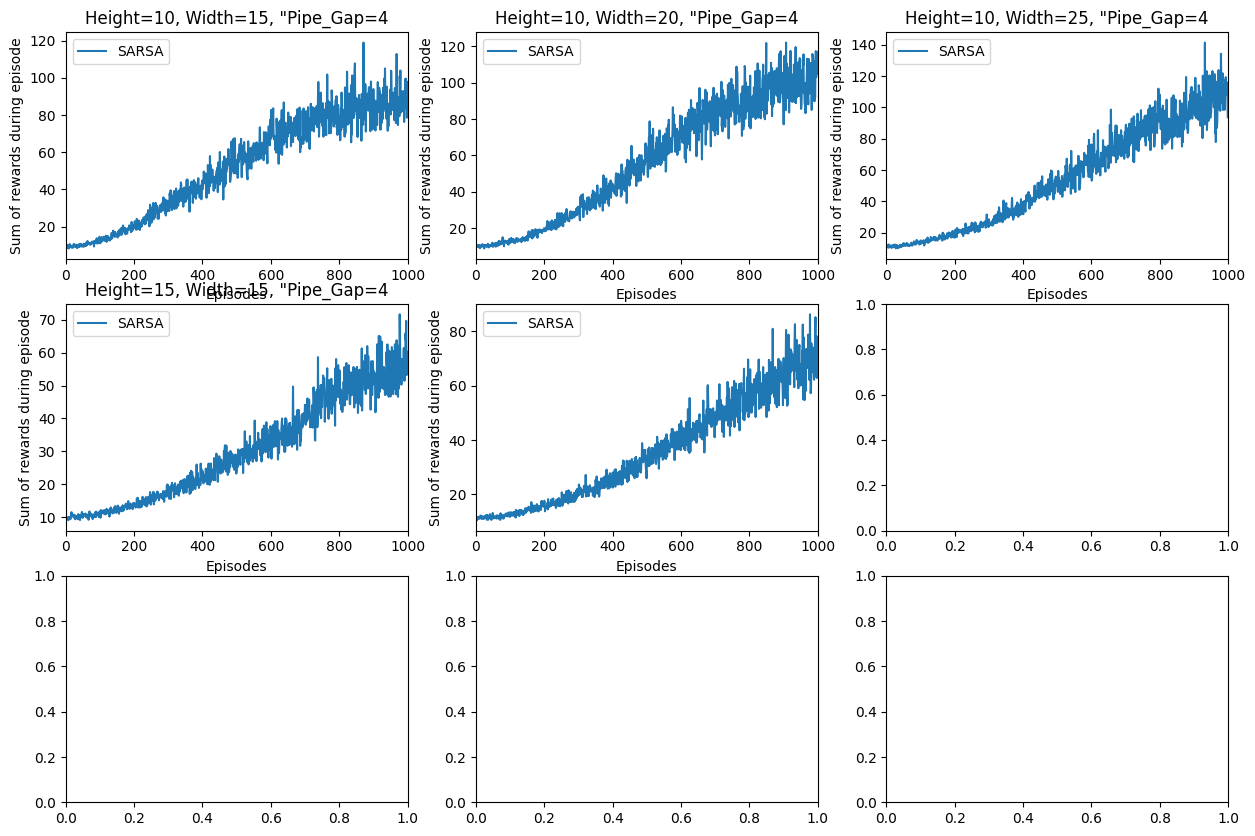

The mean score over all runs is : 6.65


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


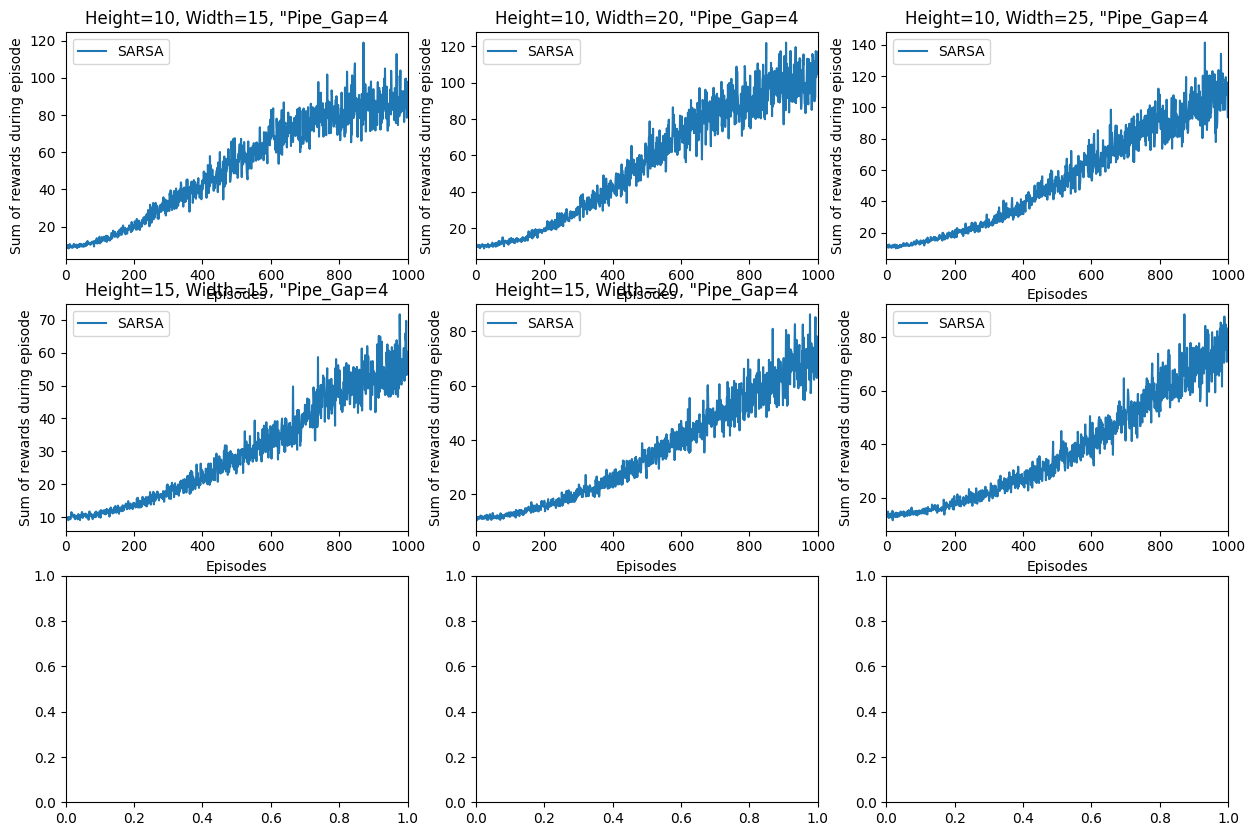

The mean score over all runs is : 4.42


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


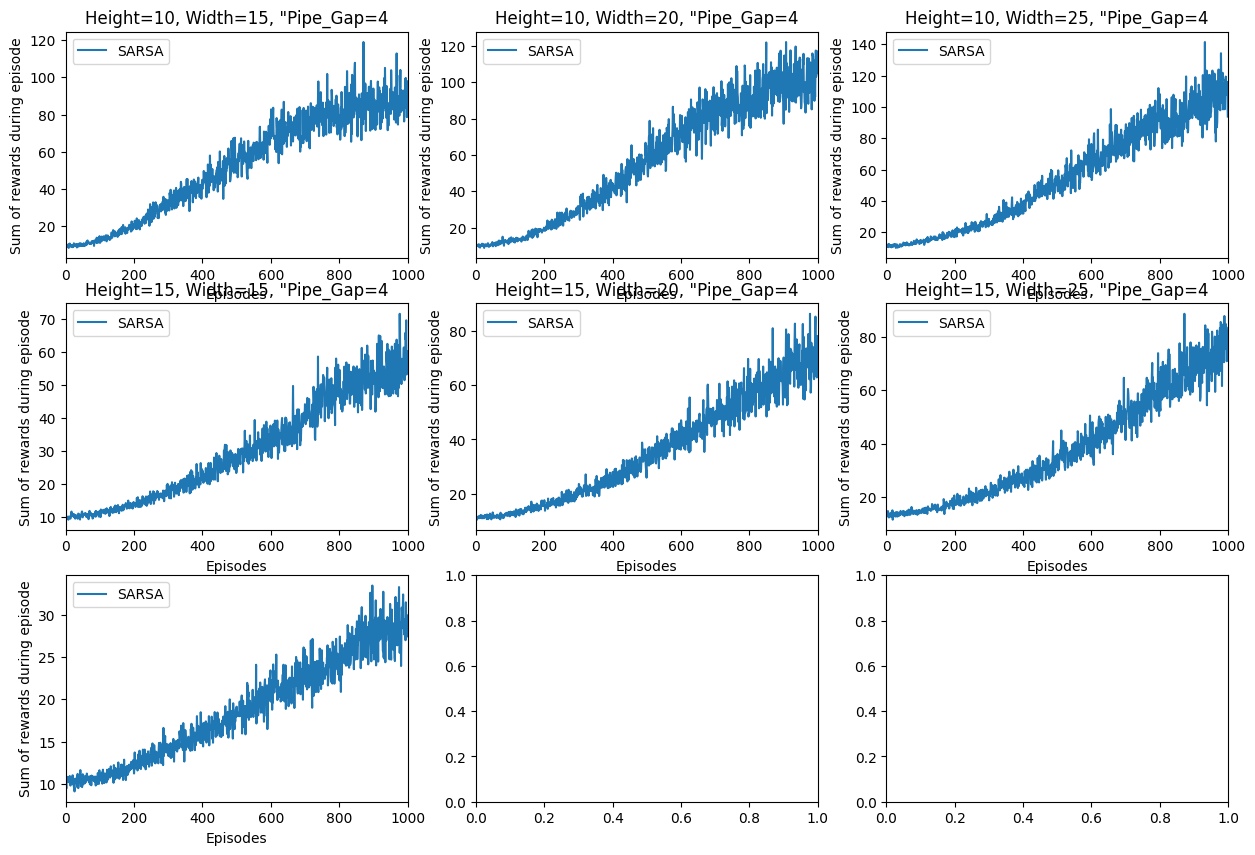

The mean score over all runs is : 2.27


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


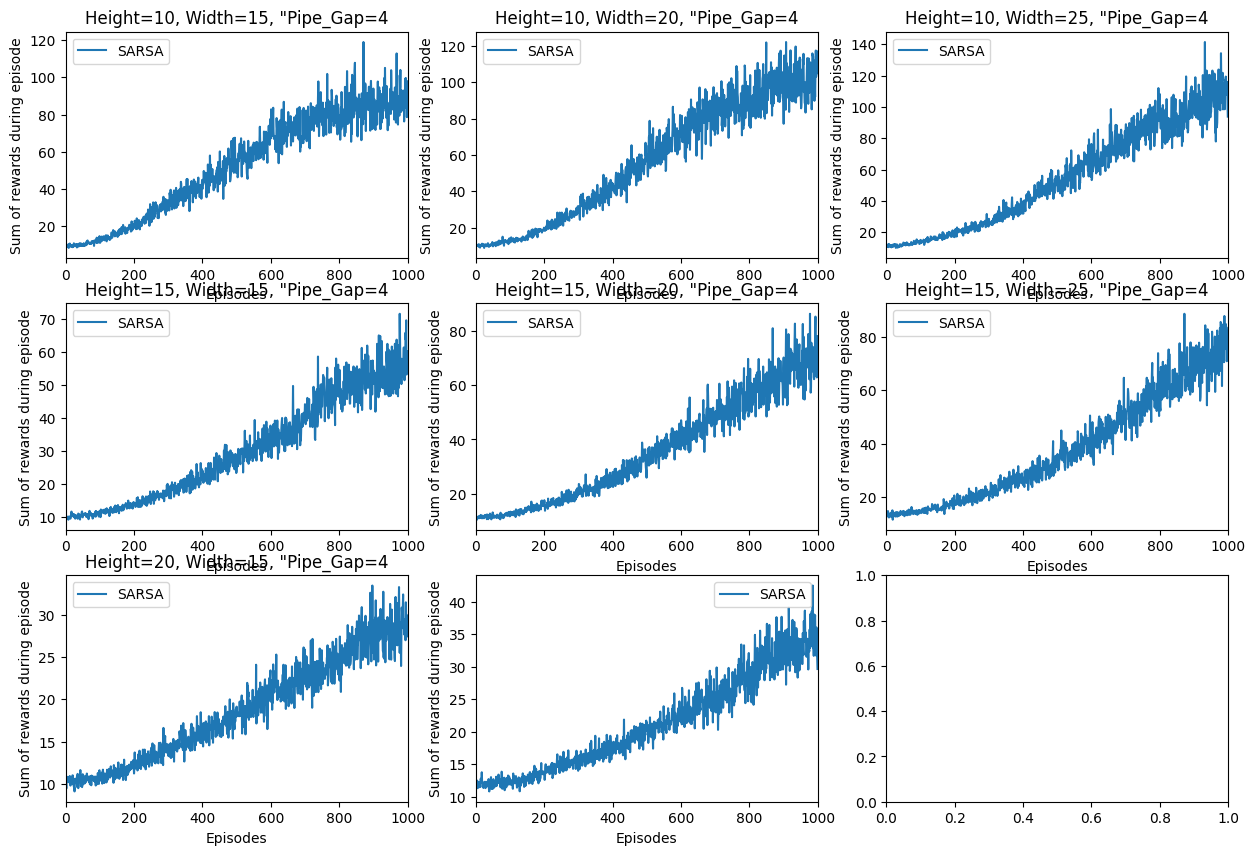

The mean score over all runs is : 1.81


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


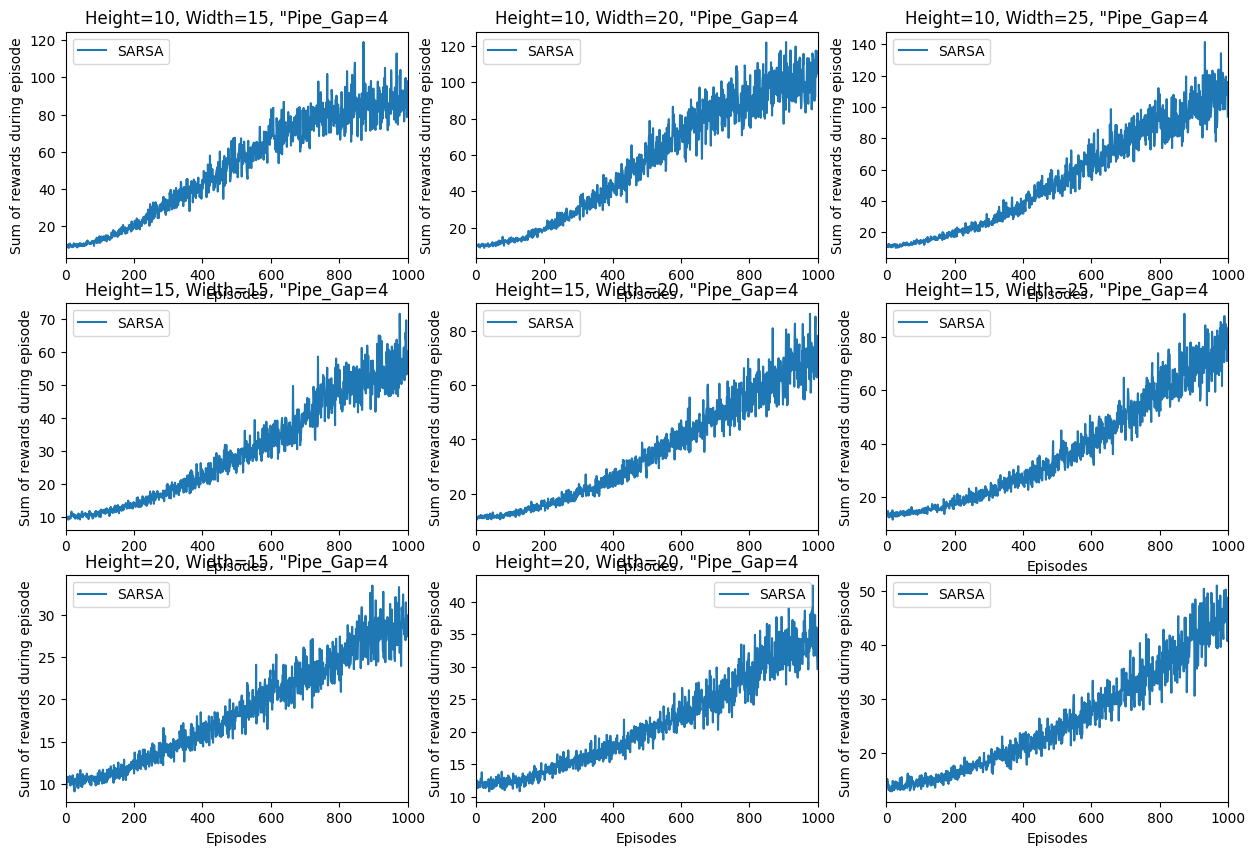

The mean score over all runs is : 2.29


<Figure size 640x480 with 0 Axes>

100%|██████████| 100/100 [12:22<00:00,  7.42s/it]


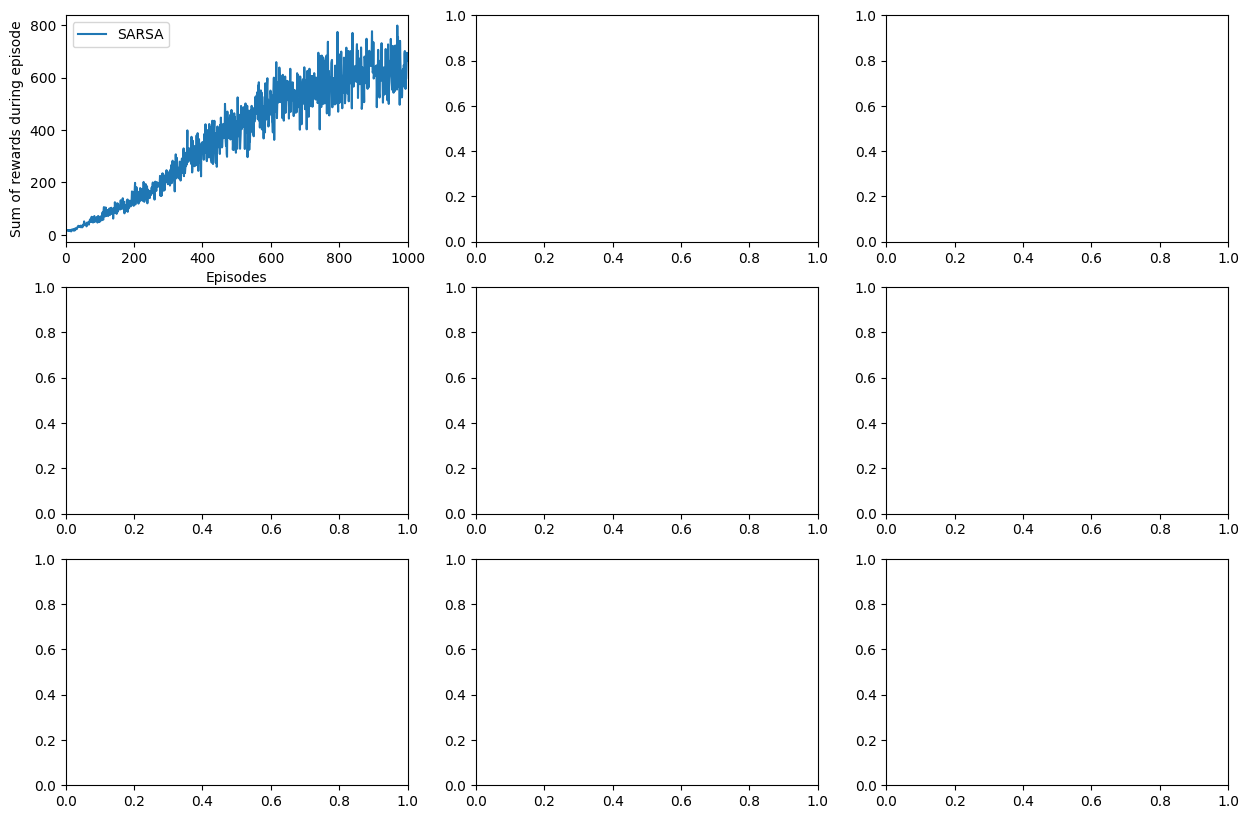

The mean score over all runs is : 81.81


100%|██████████| 100/100 [11:49<00:00,  7.09s/it]


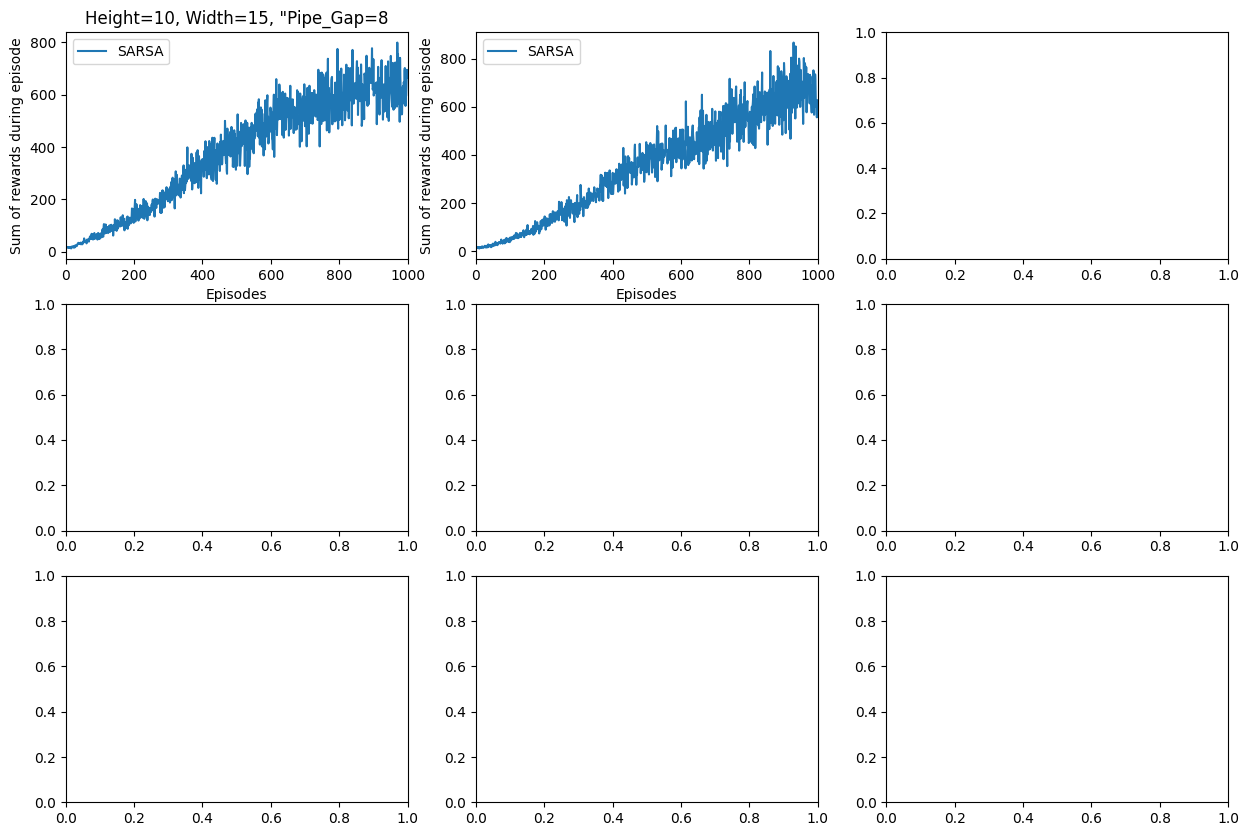

The mean score over all runs is : 61.5


100%|██████████| 100/100 [08:41<00:00,  5.22s/it]


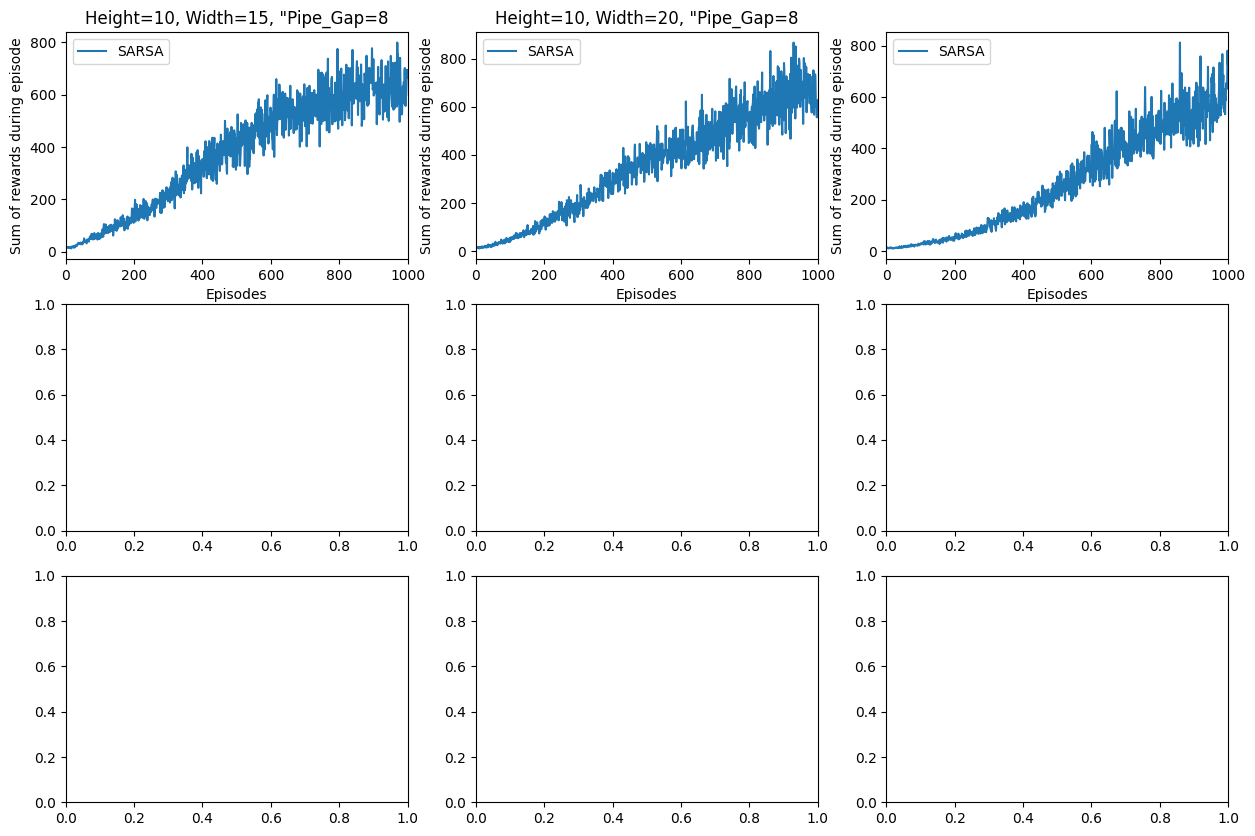

The mean score over all runs is : 54.79


100%|██████████| 100/100 [06:29<00:00,  3.89s/it]


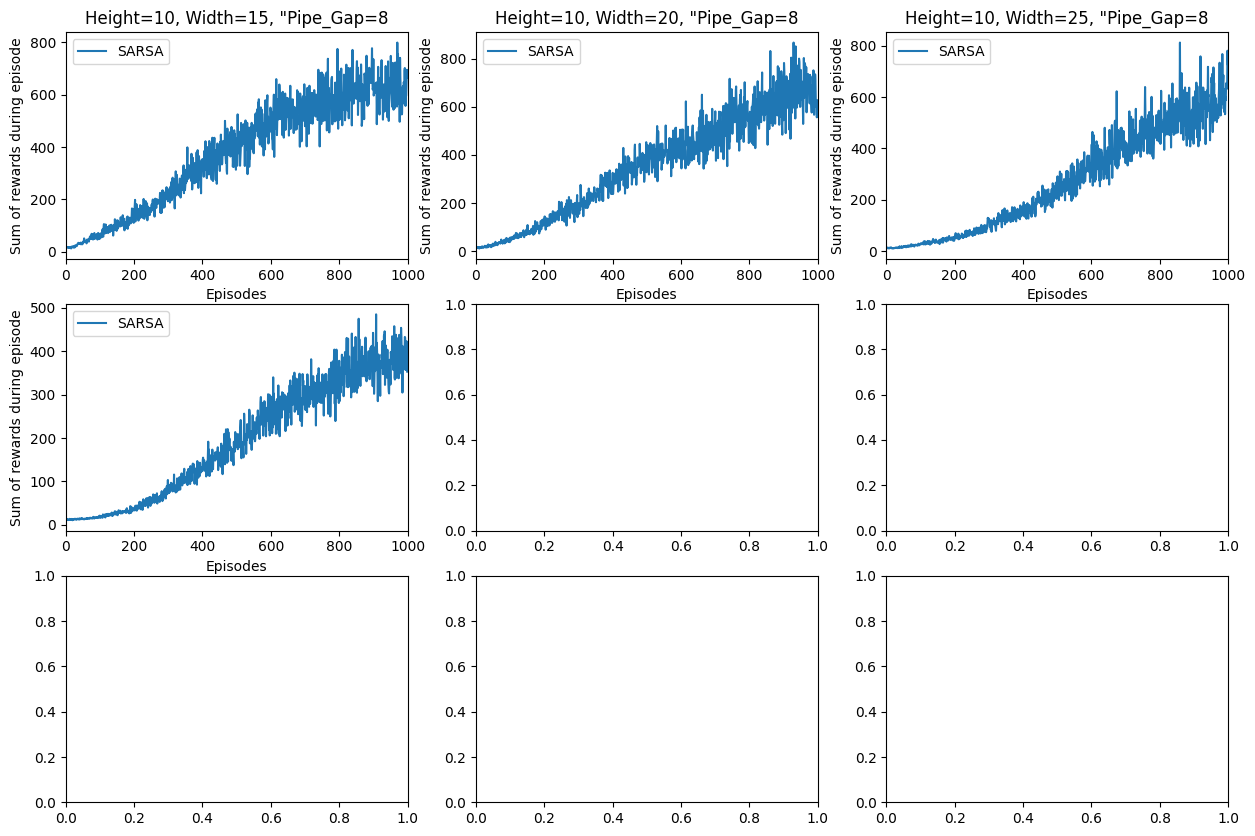

The mean score over all runs is : 42.91


 82%|████████▏ | 82/100 [05:51<01:17,  4.28s/it]


KeyboardInterrupt: 

In [ ]:
HEIGHTS = [10, 15, 20]
WIDTHS = [15, 20, 25]
GAPS = [2, 4, 8]

for gap in GAPS:
    plt.ioff()
    fig, axes = plt.subplots(len(HEIGHTS), len(WIDTHS), figsize=(15, 10))

    for i, height in enumerate(HEIGHTS):
        for j, width in enumerate(WIDTHS):
            ax = axes[i, j]
            env = gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=gap)
            plt.sca(ax)
            run_sarsa_agent(env, SARSA_AGENT_INFO)
            ax.set_title(f'Height={height}, Width={width}, "Pipe_Gap={gap}')

    plt.tight_layout()
    plt.show()